# Test validity step 3 : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$ becoming $P(r | ...) \propto s_c^t C(r)^{-1} s_c + ln|C(r)|$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro.distributions as dist

import micmac as micmac

In [2]:
PRNGKey = random.PRNGKey(0)


In [3]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [4]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


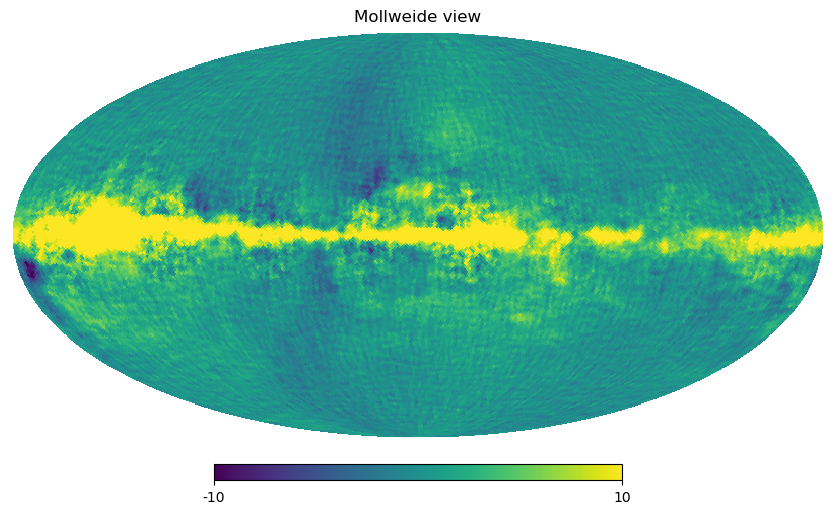

In [5]:
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, n_pix

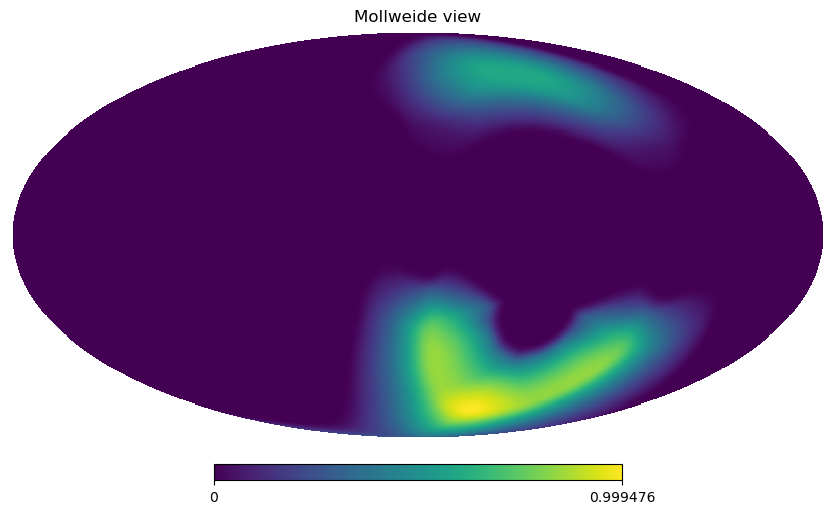

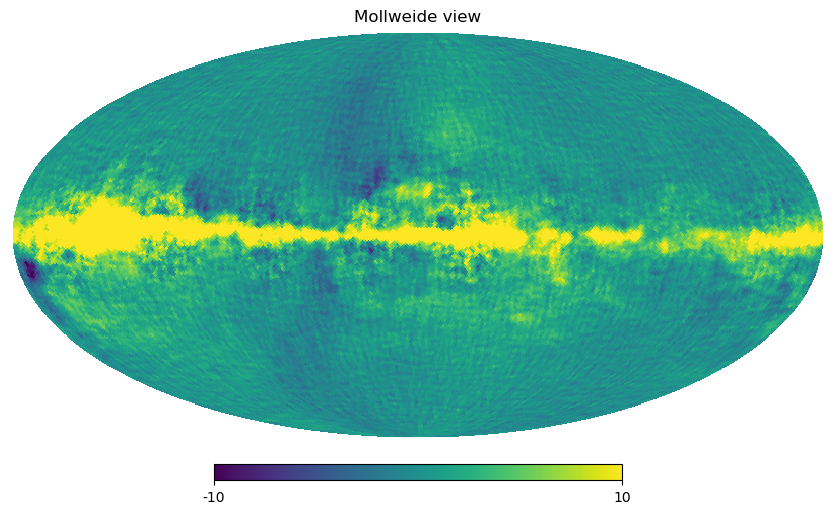

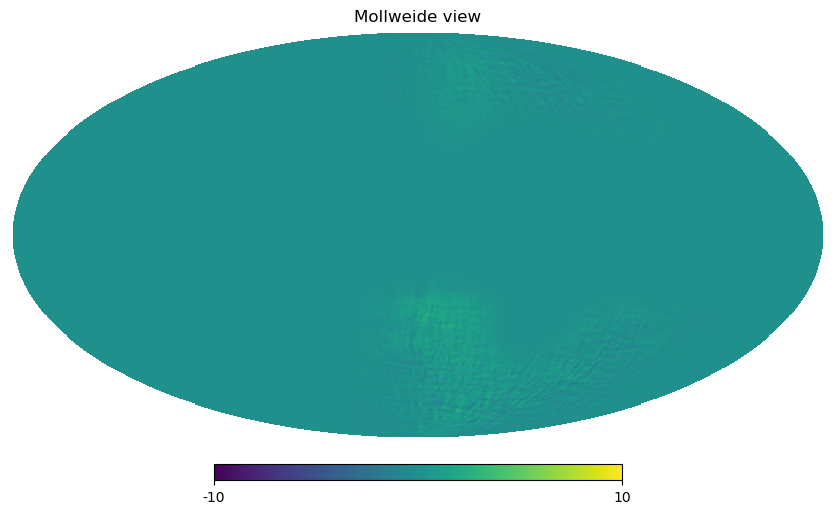

In [6]:
path_mask_test = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

mask_test = hp.read_map(path_mask_test)
hp.mollview(mask_test)
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, n_pixhp.mollview(freq_maps[0,0]) # Freq, nstokes, n_pix
hp.mollview(freq_maps[2,0]*hp.ud_grade(mask_test,nside_out=64), min=-10, max=10) # Freq, nstokes, n_pix

In [7]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_full_chain_v1d.toml'
# path_toml_file = directory_toml_file + 'corr_full_chain_v3a.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'


In [8]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [9]:
reduction_noise = 1

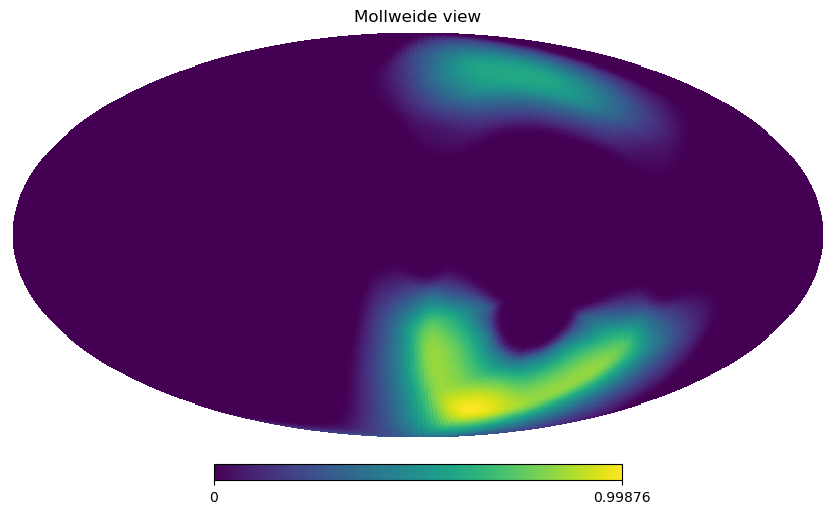

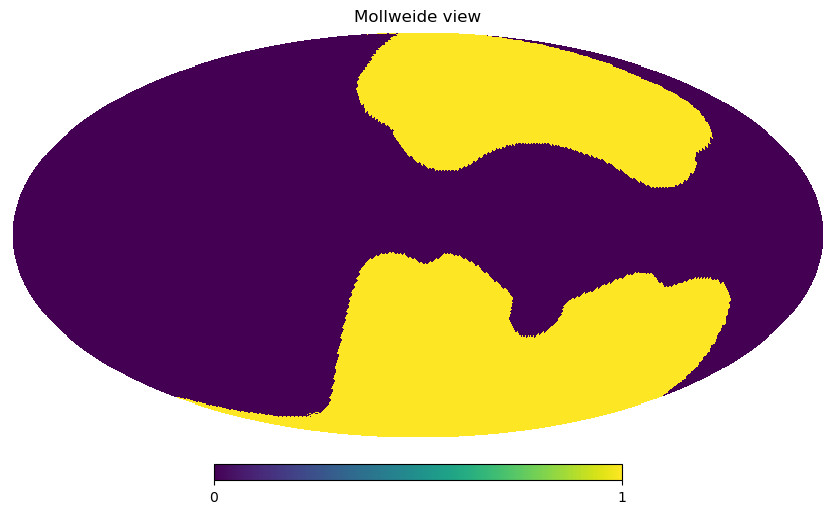

In [10]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

apod_mask = hp.ud_grade(hp.read_map(path_mask_test),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)
mask[apod_mask>0] = 1
hp.mollview(apod_mask)
hp.mollview(mask)

In [11]:
# mask = np.ones(MICMAC_sampler_obj.n_pix)

MICMAC_sampler_obj.mask = mask

In [12]:
# freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)
freq_inverse_noise_0 = micmac.get_noise_covar(instrument['depth_p'], MICMAC_sampler_obj.nside) #MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_pix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise_0.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_frequencies,nb_pixels_mask), order='C')

MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked
freq_inverse_noise = freq_inverse_noise_masked

In [13]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise)[:, 1:, :]   # keep only Q and U


In [14]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [15]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.n_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.n_components, init_params, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

# BtinvNB_fullsky = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
# BtinvN_sqrt_fullsky = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
# BtinvN_fullsky = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
# BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)#*mask

BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

nb_pix_mask = int(np.sum(mask))

# BtinvNB = np.zeros((MICMAC_sampler_obj.n_components,MICMAC_sampler_obj.n_components,MICMAC_sampler_obj.n_pix))
# BtinvNB[:,:,mask!=0] = np.repeat(BtinvNB_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.n_components, MICMAC_sampler_obj.n_components, nb_pix_mask), order='C')

# BtinvN_sqrt = np.zeros((MICMAC_sampler_obj.n_components,MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_pix))
# BtinvN_sqrt[:,:,mask!=0] = np.repeat(BtinvN_sqrt_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.n_components, MICMAC_sampler_obj.n_frequencies, nb_pix_mask), order='C')

# BtinvN = np.zeros((MICMAC_sampler_obj.n_components,MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_pix))
# BtinvN[:,:,mask!=0] = np.repeat(BtinvN_fullsky.ravel(order='C'), nb_pix_mask).reshape((MICMAC_sampler_obj.n_components, MICMAC_sampler_obj.n_frequencies, nb_pix_mask), order='C')


In [16]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask
# true_cmb_specra = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.n_frequencies).reshape((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix),order='F')

# input_cmb_maps = 

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [17]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps_masked, jax_use=False)[0, :, :]

In [18]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [19]:
n_frequencies = MICMAC_sampler_obj.n_frequencies
n_components = MICMAC_sampler_obj.n_components
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter
n_pix = 12*nside**2

In [20]:
# def test_get_fluctuating_term_maps(red_cov_matrix, invBtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_realization_xi=jnp.empty(0), map_random_realization_chi=jnp.empty(0), initial_guess=jnp.empty(0)):
#     """ 
#         Solve fluctuation term with formulation (C^-1 + N^-1) for the left member :
#         (C^{-1} + E^t (B^t N^{-1} B)^{-1} E) \zeta = C^{-1/2} xi + (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} chi

#         Parameters
#         ----------
#         param_dict : dictionnary containing the following fields : nside, nstokes, lmax
        
#         red_cov_matrix : covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
#         red_inverse_noise : matrices of inverse noise in harmonic domain (yet), dimension [lmin:lmax, nstokes, nstokes]

#         map_white_noise_xi : set of maps 0 with mean and variance 1, which will be used to compute the fluctuation term ; dimension [nstokes, n_pix]
#         map_white_noise_chi : set of maps 0 with mean and variance 1, which will be used to compute the fluctuation term ; dimension [nstokes, n_pix]
        
#         lmin : minimum multipole to be considered, default 0
        
#         n_iter : number of iterations for harmonic computations, default 8

#         limit_iter_cg : maximum number of iterations for the CG, default 1000
#         tolerance : CG tolerance, default 10**(-12)

#         Returns
#         -------
#         Fluctuation maps [nstokes, n_pix]
#     """

#         # assert red_cov_matrix.shape[0] == param_dict['lmax'] + 1 - lmin
#     chx.assert_axis_dimension(red_cov_matrix, 0, MICMAC_sampler_obj.lmax + 1 - MICMAC_sampler_obj.lmin)
#     chx.assert_axis_dimension(invBtinvNB, 2, MICMAC_sampler_obj.n_pix)
#     chx.assert_axis_dimension(BtinvN_sqrt, 2, MICMAC_sampler_obj.n_pix)

#     red_inverse_cov_matrix = jnp.linalg.pinv(red_cov_matrix)

#     jax_key_PNRG, jax_key_PNRG_xi = random.split(jax_key_PNRG)
#     # Creation of the random maps
#     if jnp.size(map_random_realization_xi) == 0:
#         print("Recalculating xi !")
#         # map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
#         map_random_realization_xi = jax.random.normal(jax_key_PNRG_xi, shape=(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix))/jhp.nside2resol(MICMAC_sampler_obj.nside)#*mask_to_use
    
#     jax_key_PNRG, *jax_key_PNRG_chi = random.split(jax_key_PNRG,MICMAC_sampler_obj.n_frequencies+1)
#     if jnp.size(map_random_realization_chi) == 0:
#         print("Recalculating chi !")
#         # map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["n_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
#         # map_random_realization_chi = jax.random.normal(jax_key_PNRG, shape=(n_frequencies,nstokes,n_pix))#/jhp.nside2resol(nside)
#         def fmap(random_key):
#             # random_map = jax.random.normal(jax_key_PNRG_chi[index_freq], shape=(nstokes,n_pix))#/jhp.nside2resol(nside)
#             random_map = jax.random.normal(random_key, shape=(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix))#/jhp.nside2resol(nside)
#             return MICMAC_sampler_obj.get_band_limited_maps(random_map)
#         map_random_realization_chi = jax.vmap(fmap)(jnp.array(jax_key_PNRG_chi))

#     # Computation of the right side member of the CG
#     red_inv_cov_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_inverse_cov_matrix)

#     # First right member : C^{-1/2} \xi
#     right_member_1 = maps_x_red_covariance_cell_JAX(map_random_realization_xi, red_inv_cov_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

#     N_c_inv = jnp.copy(invBtinvNB[0,0])
#     N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
#     N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix), order='F').ravel()
#     # N_c_inv_repeat = 1/invBtinvNB[0,0,0]

#     ## Left hand side term : (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} \chi
#     # right_member_2 = jnp.einsum('kc,cf,fsp->ksp', invBtinvNB, BtinvN_sqrt, map_random_realization_chi)[0]/invBtinvNB[0,0] # Selecting CMB component of the random variable
#     right_member_2 = jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, map_random_realization_chi)[0]*N_c_inv # Selecting CMB component of the random variable

#     right_member = (right_member_1 + right_member_2).ravel()

#     # Computation of the left side member of the CG

#     # First left member : C^{-1} 
#     first_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_inverse_cov_matrix, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
#     def first_term_left(x):
#         x_full_map = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix))
#         x_full_map = x_full_map.at[...,MICMAC_sampler_obj.mask!=0].set(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix))[...,MICMAC_sampler_obj.mask!=0])
#         return maps_x_red_covariance_cell_JAX(x_full_map, red_inverse_cov_matrix, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)[:,MICMAC_sampler_obj.mask!=0]

#     ## Second left member : (E^t (B^t N^{-1} B) E)
#     def second_term_left(x):
#         return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix))*N_c_inv[:,mask!=0]
#         # return x*N_c_inv_repeat

#     func_left_term = lambda x : first_term_left(x).ravel() + second_term_left(x).ravel()
#     # Initial guess for the CG
#     if jnp.size(initial_guess) == 0:
#         initial_guess = jnp.zeros_like(map_random_realization_xi)

#     # Actual start of the CG
#     partial_fluctuating_map, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member[:,mask!=0].ravel(), x0=initial_guess[:,mask!=0].ravel(), 
#                                                                 tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)
#     print("CG-Python-0 Fluct finished in ", number_iterations, "iterations !!")

#     fluctuating_map = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix))
#     n_pix_mask = jnp.size(MICMAC_sampler_obj.mask[MICMAC_sampler_obj.mask!=0])
#     fluctuating_map = fluctuating_map.at[...,MICMAC_sampler_obj.mask!=0].set(partial_fluctuating_map.reshape((MICMAC_sampler_obj.nstokes,n_pix_mask)))

#     fluctuating_map = fluctuating_map.at[...,MICMAC_sampler_obj.mask==0].set(0)
#     return fluctuating_map.reshape((MICMAC_sampler_obj.nstokes, MICMAC_sampler_obj.n_pix))


# def test_solve_generalized_wiener_filter_term(s_cML, red_cov_matrix, invBtinvNB, initial_guess=jnp.empty(0)):
#     """ 
#         Solve Wiener filter term with formulation (1 + C^1/2 N^-1 C^1/2) for the left member

#         Parameters
#         ----------
#         param_dict : dictionnary containing the following fields : nside, nstokes, lmax

#         s_cML : data maps, for Wiener filter CG ; dimensions [nstokes, n_pix]

#         red_cov_matrix : covariance matrices in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
#         red_inverse_noise : matrices of inverse noise in harmonic domain (yet), dimension [lmin:lmax, nstokes, nstokes]

#         map_white_noise_xi : set of maps 0 with mean and variance 1, which will be used to compute the fluctuation term ; dimension [nstokes, n_pix]
#         map_white_noise_chi : set of maps 0 with mean and variance 1, which will be used to compute the fluctuation term ; dimension [nstokes, n_pix]
        
#         lmin : minimum multipole to be considered, default 0
        
#         n_iter : number of iterations for harmonic computations, default 8

#         limit_iter_cg : maximum number of iterations for the CG, default 1000
#         tolerance : CG tolerance, default 10**(-12)

#         Returns
#         -------
#         Wiener filter maps [nstokes, n_pix]
#     """

#     # assert red_cov_matrix.shape[0] == param_dict['lmax'] + 1 - lmin
#     chx.assert_axis_dimension(red_cov_matrix, 0, MICMAC_sampler_obj.lmax + 1 - MICMAC_sampler_obj.lmin)
#     if MICMAC_sampler_obj.nstokes != 1:
#         chx.assert_axis_dimension(s_cML, 0, MICMAC_sampler_obj.nstokes)
#         chx.assert_axis_dimension(s_cML, 1, MICMAC_sampler_obj.n_pix)
#     chx.assert_axis_dimension(invBtinvNB, 2, MICMAC_sampler_obj.n_pix)

#     N_c_inv = jnp.copy(invBtinvNB[0,0])
#     N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
#     N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix), order='F').ravel()

#     # right_member = (s_cML/invBtinvNB[0,0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2).ravel()
#     right_member = (s_cML*N_c_inv).ravel()

#     # Computation of the left side member of the CG
#     first_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), jnp.linalg.pinv(red_cov_matrix), nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()
    
#     ## Second left member : (E^t (B^t N^{-1} B)^{-1} E)^{-1} x
#     def second_term_left(x, n_component=MICMAC_sampler_obj.n_components):
#         return x*N_c_inv_repeat

#     func_left_term = lambda x : first_term_left(x).ravel() + second_term_left(x).ravel()

#     # Initial guess for the CG
#     if jnp.size(initial_guess) == 0:
#         initial_guess = jnp.zeros_like(s_cML)

#     # Actual start of the CG
#     wiener_filter_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)
#     print("CG-Python-0 WF finished in ", number_iterations, "iterations !!")

#     return wiener_filter_term.reshape((MICMAC_sampler_obj.nstokes, MICMAC_sampler_obj.n_pix))


In [21]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)

N_c_inv_repeat = np.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,n_pix), order='F').ravel()

In [22]:
N_c_inv_repeat[:n_pix][N_c_inv_repeat[:n_pix]!=N_c_inv]

Array([], dtype=float64)

In [23]:
%%time
PRNGKey = random.PRNGKey(0)
map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
# fluctuation_maps = get_fluctuating_term_maps_test(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, mask_to_use=mask, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))
print("Finished fluct !")


Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
Finished fluct !
CPU times: user 35.1 s, sys: 4.76 s, total: 39.8 s
Wall time: 7.33 s


In [24]:
jitted_get_fluctuating_term_maps = jax.jit(MICMAC_sampler_obj.get_fluctuating_term_maps)

In [25]:
%%time
fluctuation_maps = jitted_get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))

Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
CPU times: user 29 s, sys: 3.28 s, total: 32.2 s
Wall time: 5.58 s


In [26]:
%%time
fluctuation_maps = jitted_get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))


CPU times: user 27 s, sys: 3.05 s, total: 30.1 s
Wall time: 4.27 s


In [27]:
%%time
fluctuation_maps = jitted_get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))


CPU times: user 26.9 s, sys: 3.02 s, total: 30 s
Wall time: 4.28 s


In [28]:
%%time
wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CG-Python-0 WF finished in  None iterations !!
CPU times: user 28.4 s, sys: 3.59 s, total: 32 s
Wall time: 4.55 s


In [29]:
jitted_solve_generalized_wiener_filter_term = jax.jit(MICMAC_sampler_obj.solve_generalized_wiener_filter_term)

In [30]:
%%time
wiener_filter_term = jitted_solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CG-Python-0 WF finished in  None iterations !!
CPU times: user 27.1 s, sys: 3.19 s, total: 30.2 s
Wall time: 4.49 s


In [31]:
%%time
wiener_filter_term = jitted_solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CPU times: user 25.8 s, sys: 2.88 s, total: 28.6 s
Wall time: 4.06 s


In [32]:
%%time
wiener_filter_term = jitted_solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CPU times: user 25.8 s, sys: 2.88 s, total: 28.7 s
Wall time: 4.06 s


In [33]:
s_c_sample = wiener_filter_term + fluctuation_maps

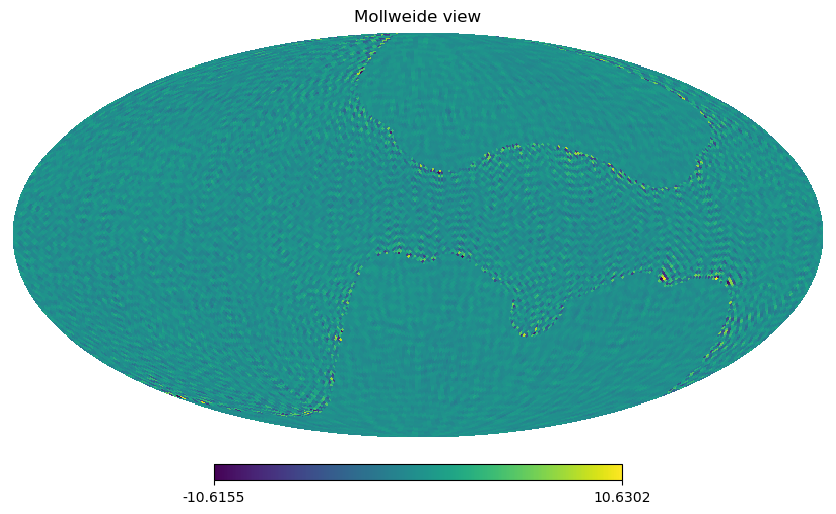

In [34]:
hp.mollview(s_c_sample[0])
hp.mollview(s_c_sample[1])

In [35]:
n_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = n_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [36]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

In [37]:
fsky = mask.sum()/mask.size
fsky = 1#mask.sum()/mask.size

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


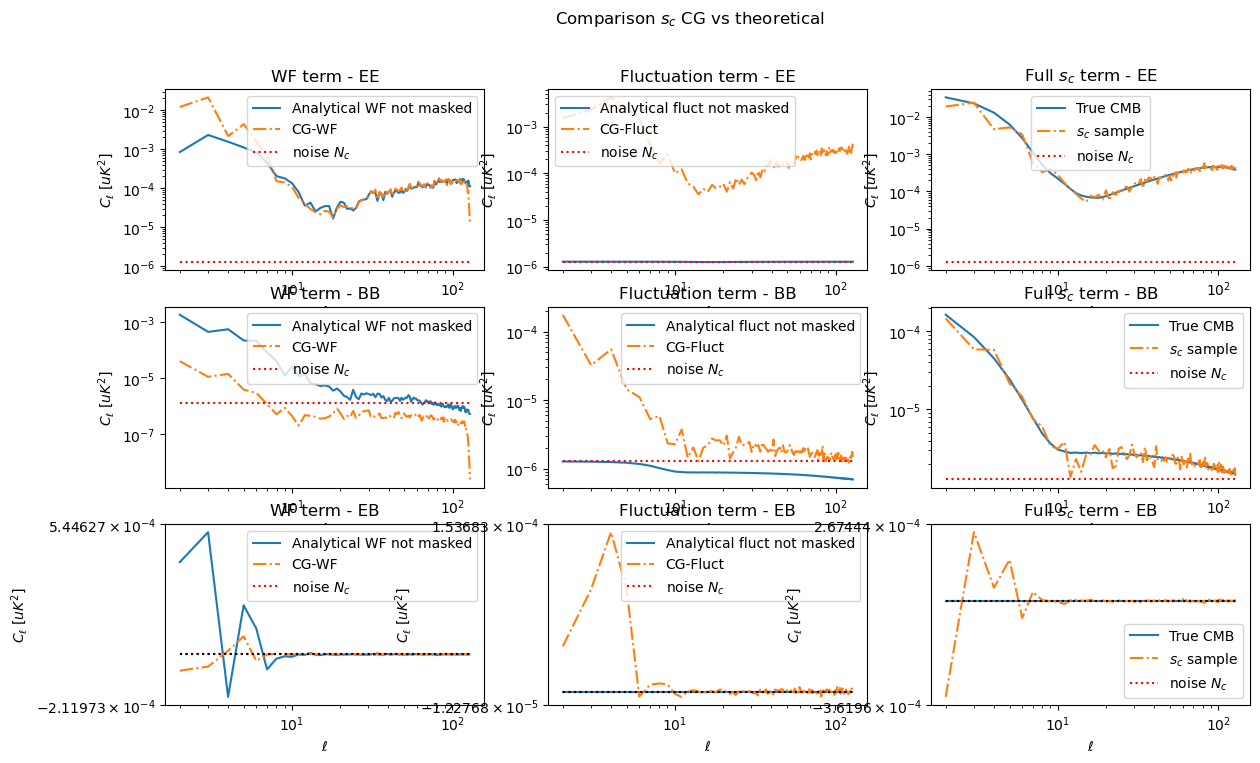

In [38]:
list_correl = ['EE', 'BB', 'EB']

c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)

# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
#                                                                         analytical_WF_harm, lmin=lmin, n_iter=n_iter)

s_cML_unmasked = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML_unmasked/BtinvNB[0,0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(n_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF not masked')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:]/fsky, '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct not masked')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:]/fsky, '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:]/fsky, '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()

In [39]:
# number_steps_sampler = 5000
number_steps_sampler = 5000
# number_steps_sampler = 100
initial_step_size_r = 10**(-3)
# initial_step_size_r = 10**(-6)
initial_guess_r = 1e-2
initial_guess_r = 1e-4
# initial_guess_r = MICMAC_sampler_obj.r_true*0.99999

num_sample_AM = 1000
epsilon_cov = 10**(-20)
scale_param = 2.4**2

In [40]:
c_ells_Wishart = jnp.zeros((3,lmax+1))
# c_ells_Wishart = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)
# c_ells_Wishart = c_ells_Wishart.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

c_ells_Wishart = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)

In [41]:
c_ells_Wishart_modified = jnp.copy(c_ells_Wishart)
# for i in range(self.nstokes):
for i in range(c_ells_Wishart.shape[0]):
        c_ells_Wishart_modified = c_ells_Wishart_modified.at[i].set(c_ells_Wishart_modified[i] * (2*jnp.arange(MICMAC_sampler_obj.lmax+1) + 1))
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell_jax(c_ells_Wishart_modified)[MICMAC_sampler_obj.lmin:]


In [42]:
%%time

all_r_sample = jnp.zeros(number_steps_sampler+1)
all_r_sample = all_r_sample.at[0].set(initial_guess_r)

# all_r_sample_slow = jnp.zeros(number_steps_sampler+1)
# all_r_sample_slow = all_r_sample_slow.at[0].set(initial_guess_r)

for i in range(0,number_steps_sampler+1):
    old_PRNGKey, PRNGKey = random.split(PRNGKey)
    if i < num_sample_AM:
        step_size_r = initial_step_size_r
    else:
        step_size_r = jnp.sqrt(scale_param*(jnp.var(all_r_sample[:i]) + epsilon_cov))
    if i%100 == 0:
        print(i, step_size_r)
    all_r_sample = all_r_sample.at[i+1].set(single_lognormal_Metropolis_Hasting_step(random_PRNGKey=PRNGKey, old_sample=all_r_sample[i], 
                                        step_size=step_size_r, log_proba=MICMAC_sampler_obj.get_conditional_proba_C_from_r, 
                                        red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))


0 0.001
100 0.001
200 0.001
300 0.001
400 0.001
500 0.001
600 0.001
700 0.001
800 0.001
900 0.001
1000 0.0033310173743896212
1100 0.0031826285698727556
1200 0.0030527183140763286
1300 0.0029506124629735445
1400 0.002859501691327599
1500 0.0027673453425645926
1600 0.0026832041069749265
1700 0.0026121687152337114
1800 0.002546636646708281
1900 0.0024913639355653976
2000 0.0024352963517415603
2100 0.0023873073812897645
2200 0.0023382640429873355
2300 0.0022907567923697346
2400 0.0022510911903867127
2500 0.002214792170367717
2600 0.0021796817885936393
2700 0.0021463954371499865
2800 0.002115459244103134
2900 0.002084590413019336
3000 0.0020554867604271137
3100 0.002027119614052841
3200 0.002003063070854315
3300 0.0019788558751270553
3400 0.001954612050455003
3500 0.001934117704737896
3600 0.0019128389214538696
3700 0.0018910846492295153
3800 0.0018733582641140068
3900 0.0018537497695246298
4000 0.001837875584808816
4100 0.0018196262591611975
4200 0.001806235384534799
4300 0.001790863751177

In [43]:
log_space_r = np.logspace(-8,3, num=100)

if MICMAC_sampler_obj.r_true != 0:
        log_r_true = np.log10(MICMAC_sampler_obj.r_true)
        gap = .1
        log_space_r = np.logspace(log_r_true-gap,log_r_true+gap, num=100)
else:
        log_space_r = np.logspace(-20,-2, num=100)
c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]

all_logproba_r = np.array([MICMAC_sampler_obj.get_conditional_proba_C_from_r(r_logspace, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

In [44]:
all_logproba_samples = np.array([MICMAC_sampler_obj.get_conditional_proba_C_from_r(r_sample, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_sample in all_r_sample])

In [45]:
r_fit = all_r_sample.mean()
print('R_fit :', r_fit)
r_max = log_space_r[np.where(all_logproba_r==all_logproba_r.max())[0][0]]
print('R_max :', r_max)

R_fit : 0.01016119706730332
R_max : 0.0101641416082135


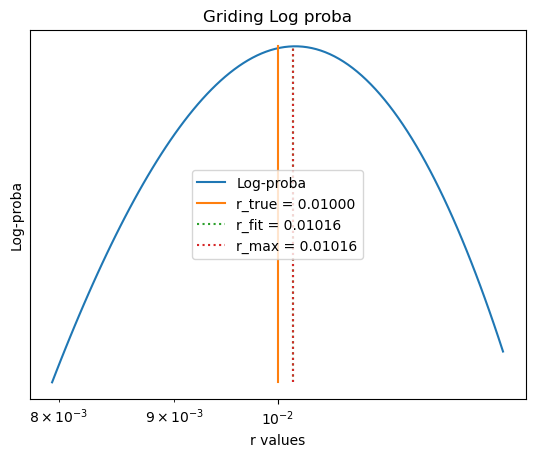

In [46]:
plt.plot(log_space_r, all_logproba_r, label='Log-proba')
plt.plot([MICMAC_sampler_obj.r_true, MICMAC_sampler_obj.r_true], [all_logproba_r.min(), all_logproba_r.max()], label='r_true = {:.5f}'.format(MICMAC_sampler_obj.r_true))
plt.plot([r_fit, r_fit], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_fit = {:.5f}'.format(r_fit))
plt.plot([r_max, r_max], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_max = {:.5f}'.format(r_max))
# plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('r values')
plt.ylabel('Log-proba')
plt.title('Griding Log proba')
# plt.ylim(ymax=all_logproba_r.max())
plt.legend()
plt.show()

In [47]:
all_r_sample.shape

(5001,)

In [48]:
red_c_ells_samples = np.zeros((number_steps_sampler, lmax+1-lmin, nstokes, nstokes))

for i in range(number_steps_sampler):
    red_c_ells_samples[i,...] = theoretical_red_cov_r0_total + all_r_sample[i]*theoretical_red_cov_r1_tensor


In [49]:
plt.figure(figsize=(14,5))

n_sigma = 3
transformed_samples = np.abs(all_r_sample - all_r_sample.mean())/(all_r_sample.std()) #< n_sigma
cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
mean_r = np.round(all_r_sample[cond].mean(), decimals=5)
std_r = np.round(all_r_sample[cond].std(), decimals=5)
plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (99.7%)")

plt.subplot(121)
plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler+1), all_r_sample, '-.', label='samples')
# plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
plt.title('')
# plt.loglog()
plt.yscale('log')
plt.legend()

plt.subplot(122)
plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler+1), all_r_sample, '-.', label='samples')
# plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
# plt.loglog()
plt.yscale('log')
plt.legend()
plt.ylim(ymin=MICMAC_sampler_obj.r_true*.9, ymax=MICMAC_sampler_obj.r_true*1.1)
plt.show()

plt.show()

In [50]:
log_proba_r_true = MICMAC_sampler_obj.get_conditional_proba_C_from_r(MICMAC_sampler_obj.r_true, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total)

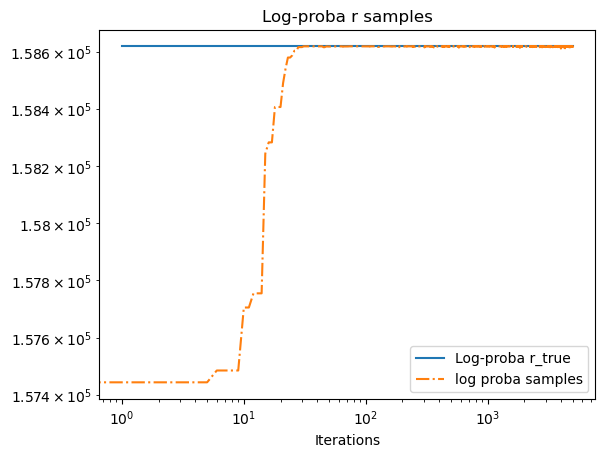

In [51]:
plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), all_logproba_samples[:], '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Log-proba r samples')
plt.loglog()
plt.legend()
plt.show()

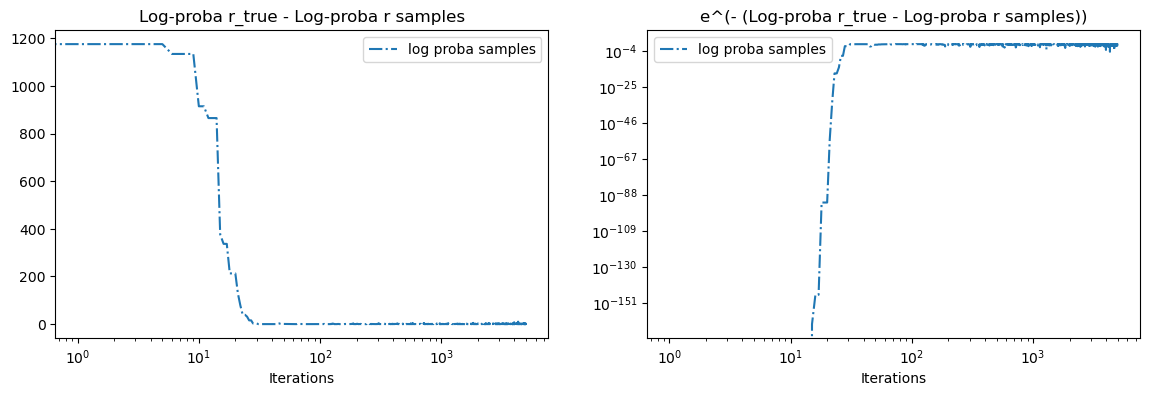

In [52]:
plt.figure(figsize=(14,4))
plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), -(all_logproba_samples[:]-log_proba_r_true), '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Log-proba r_true - Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()
plt.subplot(122)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), np.exp(all_logproba_samples[:]-log_proba_r_true), '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('e^(- (Log-proba r_true - Log-proba r samples))')
plt.loglog()
plt.legend()
plt.show()

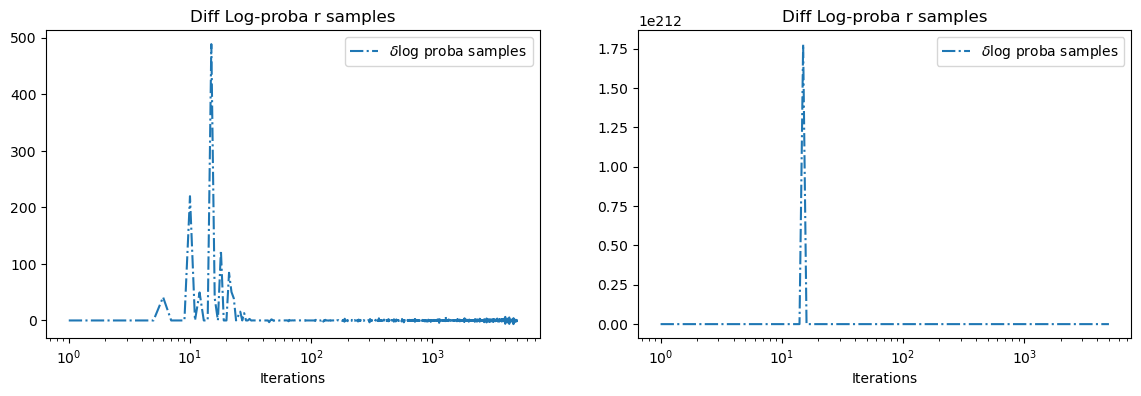

In [53]:
plt.figure(figsize=(14,4))
plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler)+1, all_logproba_samples[1:]-all_logproba_samples[:-1], '-.', label='$\delta$log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Diff Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(number_steps_sampler)+1, np.exp(all_logproba_samples[1:]-all_logproba_samples[:-1]), '-.', label='$\delta$log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Diff Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()
plt.show()